In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import to_hex
from matplotlib import ticker
import joblib

import sys
sys.path.append("../scripts")
from experiments import load_split

from credit_pipeline.training import EBE # small fix to be able to load models
from credit_pipeline.training import ks_threshold
from credit_pipeline.explainability import *
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
os.makedirs("explainability_data", exist_ok = True)

## Configuration

In [3]:
dataset_name = "homecredit"
seed = 0
selected_fold = 0

In [4]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_split(
    dataset_name, selected_fold, seed
)

background_samples = 100
n_samples = 1000
X_background = X_train.sample(n = background_samples, random_state = seed)
X_sample = X_train.sample(n = n_samples, random_state = seed)

## Global Importances

In [5]:
def parallel_coordinates(
    df,
    columns,
    columns_ranges = None,
    columns_tick_format = None,
    columns_names = None,
    color_column = None,
    color_mapper = None,
    name_mapper = None,
    legend_order = None,
    title = None
):
    """
    Simple parallel coordinates to plot the projection results.
    """
    norm_df = df.copy() # dataframe will be normalized

    fig, axes = plt.subplots(len(columns)-1, 1, sharex=False, figsize=(5,10))

    if columns_ranges is None:
        columns_ranges = [None for _ in columns]
    if columns_tick_format is None:
        columns_tick_format = [lambda x : np.round(x, 1) for _ in columns]

    # Get min, max and range for each column
    # Normalize the data for each column
    min_max_range = {}
    for i, col in enumerate(columns):
        if columns_ranges[i] is None:
            col_max = df[col].max()
            col_min = df[col].min()
        else:
            col_max = columns_ranges[i][1]
            col_min = columns_ranges[i][0]

        min_max_range[col] = [col_min, col_max]
        col_range = col_max - col_min
        if col_range == 0:
            col_range = 1
        norm_df[col] = (df[col] - col_min) / col_range

    # Invert to plot first columns at the top
    x = list(range(len(columns)))[::-1]
    axx = axes[0].twiny()
    # Plot each row
    if color_column is None:
        for i, ax in enumerate(axes):
            for idx in norm_df.index:
                ax.plot(norm_df.loc[idx, columns], x, c = "#80b1d3", lw = 3)
        for idx in norm_df.index:
            axx.plot(norm_df.loc[idx, columns], x, c = "#80b1d3", lw = 3)
    else:
        color_values = norm_df[color_column].unique()
        colormap = plt.get_cmap("Paired")
        if color_column is not None and color_mapper is None:
            color_mapper = {color_value: colormap(i) for i, color_value in enumerate(color_values)}

        for ii, value in enumerate(color_values):
            df_value = norm_df[norm_df[color_column] == value]
            for i, ax in enumerate(axes[:-1]):
                for idx in df_value.index:
                    ax.plot(df_value.loc[idx, columns], x, alpha = 0.85, lw = 5, label = value, c = color_mapper[value])
            for idx in df_value.index:
                axx.plot(df_value.loc[idx, columns], x, alpha = 0.85, lw = 5, label = value, c = color_mapper[value])
    
    for i, ax in enumerate(axes):
        ax.set_ylim([x[i+1], x[i]])
        ax.set_xlim([-0.05, 1.05])
        xticks = ax.get_xticks()
        col_min = min_max_range[columns[i]][0]
        col_max = min_max_range[columns[i]][1]
        col_range = col_max - col_min
        format_ = columns_tick_format[i]
        ax.set_xticklabels([format_(yi * col_range  + col_min)  for yi in xticks], fontsize = 14)
    
    axes[0].set_xlim([-0.05, 1.05])

    for i, ax in enumerate(axes):
        #ax.yaxis.set_major_locator(ticker.FixedLocator([i+1]))
        ax.set_yticks([len(axes) - i])
        ax.set_yticklabels([columns_names[i]], fontsize = 18)

    axes[-1].set_yticks([0, 1])
    axes[-1].set_yticklabels([columns_names[-2], columns_names[-1]], fontsize = 18)

    # tick for right side of last axis
    axx.set_facecolor("none")
    xticks = axes[-1].get_xticks()
    col_min = min_max_range[columns[len(axes)]][0]
    col_max = min_max_range[columns[len(axes)]][1]
    col_range = col_max - col_min
    format_ = columns_tick_format[len(axes)]
    if format_ is None:
        axx.set_xticklabels([np.round((yi * col_range +  col_min), 1)  for yi in xticks], fontsize = 14)
    else:
        axx.set_xticklabels([format_(yi * col_range +  col_min)  for yi in xticks], fontsize = 14)
    #axx.xaxis.tick_top()
    #axx.set_axisbelow(True)
    #axx.set_xlim([-0.05, 1.05])
    #axx.spines['top'].set_visible(False)
    #axx.spines['bottom'].set_visible(False)

    for ax in list(axes) + [axx]:
        ax.set_facecolor("none")
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)


    
    if title:
        plt.suptitle(title, y = 1, fontsize = 20)
    # Remove space between subplots
    plt.subplots_adjust(hspace=0)

    if color_column is not None:
        handles = [
            mpatches.Patch(color=to_hex(color_mapper[value]), label=name_mapper[value]) for value in legend_order
        ]
        plt.legend(handles = handles, bbox_to_anchor=(1.3, 1), ncol = len(legend_order))

In [6]:
path = "../results/credit_models"
lr_features_importance = []
lgbm_features_importance = []
shap_lr_features_importance = []
shap_lgbm_features_importance = []


for fold in range(10):
    X_train, Y_train, X_val, Y_val, X_test, Y_test = load_split(
        dataset_name, fold, seed
    )
    model = joblib.load(f'{path}/{dataset_name}/{fold}/LogisticRegression.pkl')
    Y_score = model.predict_proba(X_val)[:, 1]
    threshold = ks_threshold(Y_val, Y_score)
    lr_features_importance.append(model[-1].coef_[0])
    explainer = ShapPipelineExplainer(
        model,
        X_train.sample(n = background_samples, random_state = seed),
        method_explain="pred",
        threshold = threshold
    )
    importances = explainer(X_train.sample(n = n_samples, random_state = seed))
    shap_lr_features_importance.append(importances.abs().mean().values)

    features_names = importances.columns.tolist()

    model = joblib.load(f'{path}/{dataset_name}/{fold}/LGBMClassifier.pkl')
    Y_score = model.predict_proba(X_val)[:, 1]
    threshold = ks_threshold(Y_val, Y_score)
    lgbm_features_importance.append(model[-1].feature_importances_ / sum(model[-1].feature_importances_))
    explainer = ShapPipelineExplainer(
        model,
        X_train.sample(n = background_samples, random_state = seed),
        method_explain="pred",
        threshold = threshold
    )
    importances = explainer(X_train.sample(n = n_samples, random_state = seed))
    shap_lgbm_features_importance.append(importances.abs().mean().values)


lr_features_importance = pd.DataFrame(
    np.array(lr_features_importance), columns = features_names
) 
lgbm_features_importance = pd.DataFrame(
    np.array(lgbm_features_importance), columns = features_names
)
shap_lr_features_importance = pd.DataFrame(
    np.array(shap_lr_features_importance), columns = features_names
)
shap_lgbm_features_importance = pd.DataFrame(
    np.array(shap_lgbm_features_importance), columns = features_names
)

PermutationExplainer explainer: 1001it [02:10,  7.26it/s]                                                                                                                                   
PermutationExplainer explainer: 1001it [02:54,  5.41it/s]                                                                                                                                   
PermutationExplainer explainer: 1001it [02:05,  7.29it/s]                                                                                                                                   
PermutationExplainer explainer: 1001it [02:17,  6.71it/s]                                                                                                                                   
PermutationExplainer explainer: 1001it [02:06,  7.28it/s]                                                                                                                                   
PermutationExplainer explainer:  57%|██████████████████

KeyboardInterrupt: 

In [ ]:
lr_features_importance.to_csv("explainability_data/lr_features_importance.csv", index = False)
lgbm_features_importance.to_csv("explainability_data/lgbm_features_importance.csv", index = False)
shap_lr_features_importance.to_csv("explainability_data/shap_lr_features_importance.csv", index = False)
shap_lgbm_features_importance.to_csv("explainability_data/shap_lgbm_features_importance.csv", index = False)

In [ ]:
lr_features_importance = pd.read_csv("explainability_data/lr_features_importance.csv")
lgbm_features_importance = pd.read_csv("explainability_data/lgbm_features_importance.csv")
shap_lr_features_importance = pd.read_csv("explainability_data/shap_lr_features_importance.csv")
shap_lgbm_features_importance = pd.read_csv("explainability_data/shap_lgbm_features_importance.csv")

In [ ]:
def filter_importance_features(df_importance):
    """Get the median (abs) importance of each feature and select the 10 featuers with highest median importance."""
    importance_values = df_importance.values
    median_importance = np.median(np.abs(importance_values), axis=0)
    sorted_idx = np.argsort(median_importance)[::-1][:10]
    features = df_importance.columns.tolist()
    features_sorted = np.array(features)[sorted_idx]
    return features_sorted

In [21]:
def plot_pc_importances(df_importance, title = "", filename = "plot"):
    features = filter_importance_features(df_importance).tolist()
    n_f = len(features)
    imp_range = [
        df_importance[features].values.min(), df_importance[features].values.max()
    ]
    tick_format = lambda x : f"{x:.2f}"
    parallel_coordinates(
        df_importance,
        features,
        columns_ranges = [imp_range for _ in range(n_f)],
        columns_tick_format = [tick_format for _ in range(n_f)],
        columns_names = features,
        title = title
    )
    plt.savefig(f"explainability_data/{filename}.pdf", dpi = 300)

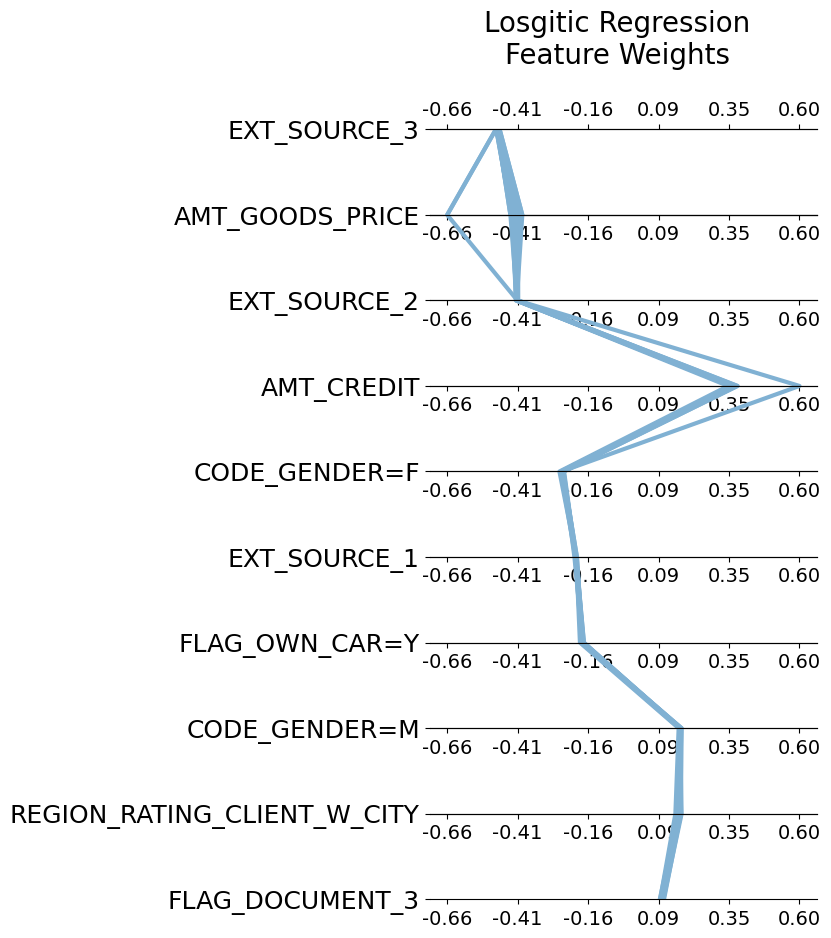

In [41]:
plot_pc_importances(lr_features_importance, "Losgitic Regression\nCoefficients", "lr_importances")

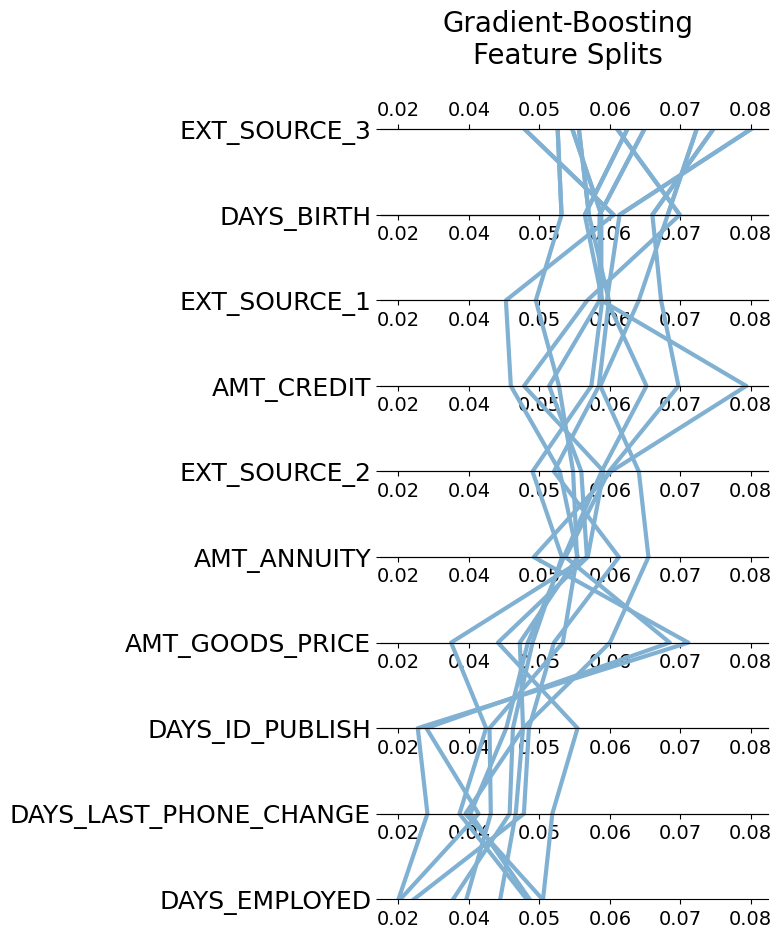

In [42]:
plot_pc_importances(lgbm_features_importance, "Gradient-Boosting\nFeature Splits", "lgbm_splits")

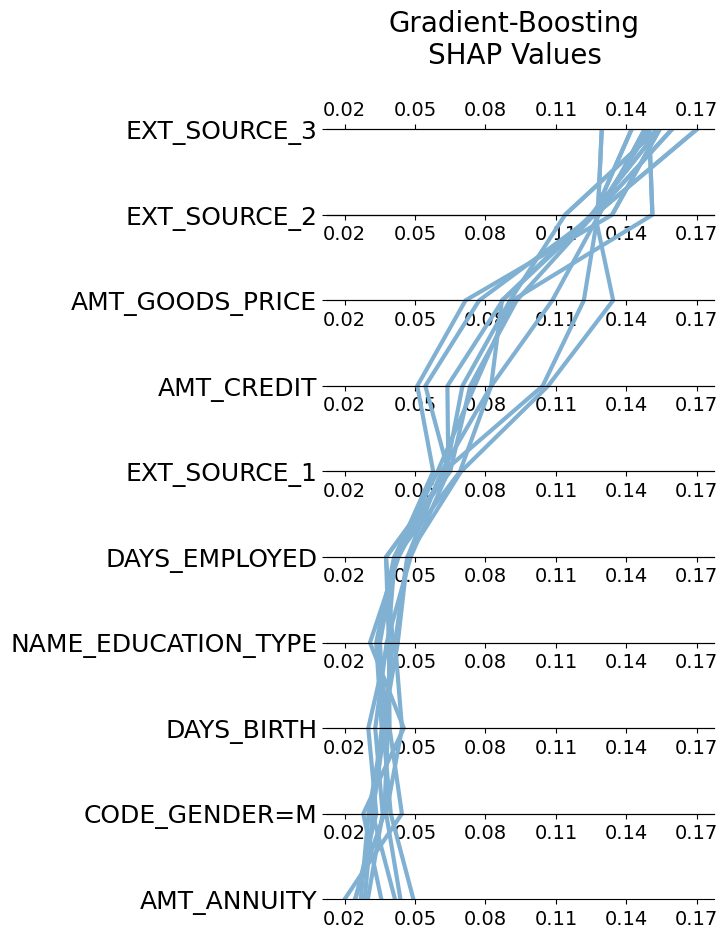

In [43]:
plot_pc_importances(shap_lgbm_features_importance, "Gradient-Boosting\nSHAP Values", "lgbm_shap")

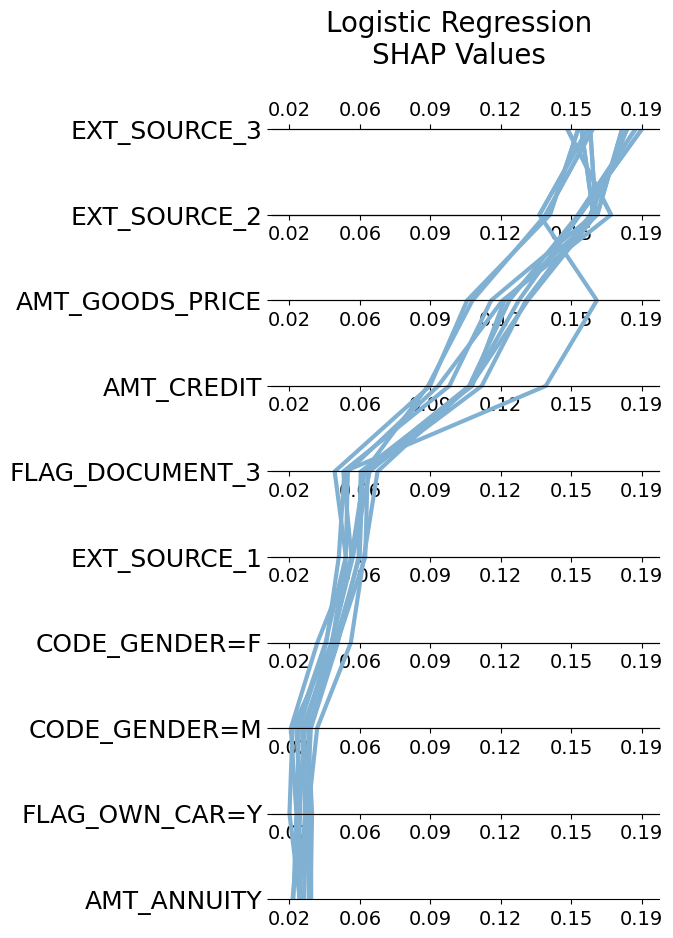

In [44]:
plot_pc_importances(shap_lr_features_importance, "Logistic Regression\nSHAP Values", "lr_shap")

## PDP

In [91]:
model_list = [
    joblib.load(f'../results/credit_models/{dataset_name}/{selected_fold}/{model_name}.pkl')
    for model_name in ["LogisticRegression", "MLPClassifier", "RandomForestClassifier", "LGBMClassifier"]
]

In [92]:
def plot_pdp(model_list, X, selected_feature):
    fig, axs = plt.subplots(nrows = 1, ncols = len(model_list), figsize = (15, 4))
    better_names = {
        "LogisticRegression": "Logistic Regression",
        "MLPClassifier": "Neural Network",
        "RandomForestClassifier": "Random Forest",
        "LGBMClassifier": "Gradient-Boosting"
    }
    for i, model in enumerate(model_list):
        explainer = PartialDependencePipeline(model)
        pdp = explainer(X, selected_feature)
        axs[i].plot(pdp["values"], pdp["prediction"])
        axs[i].set_title(better_names[model[-1].__class__.__name__])
        axs[i].set_xlabel(selected_feature)
        axs[i].set_ylabel("Probability of Default")

        for decile in pdp["deciles"]:
            axs[i].axvline(decile, ymin = 0, ymax = 0.05, color = "#606060", alpha = 0.9)

        
        xticks = [0.2e6, 0.55e6, 0.9e6, 1.25e6]
        axs[i].set_xticks(xticks)
        axs[i].set_xticklabels(["{:.1E}".format(x) for x in xticks])


    
    plt.suptitle(f"Partial Dependence Plot for {selected_feature}", fontsize = 16)
    plt.tight_layout()

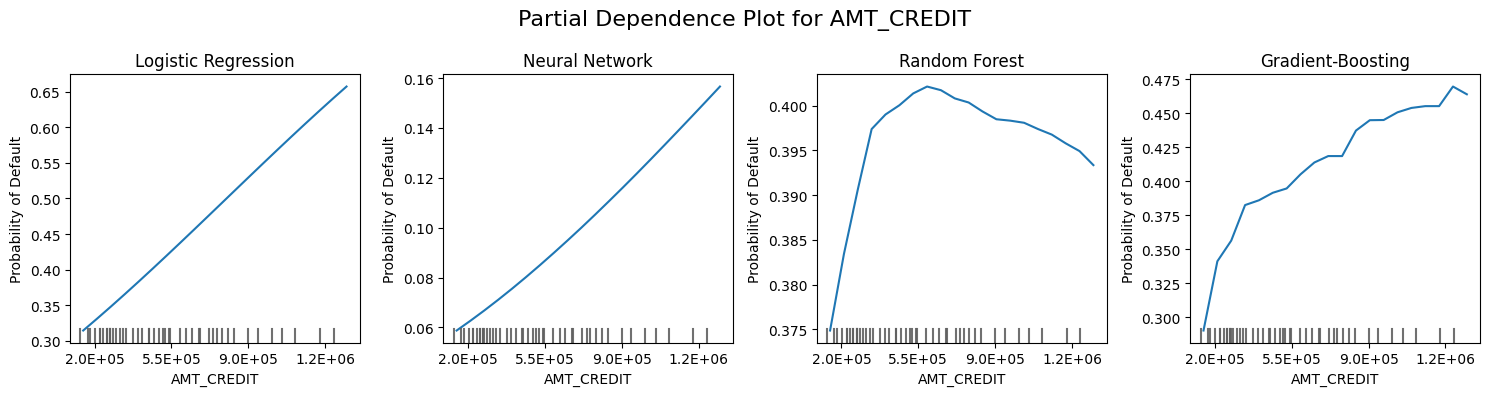

In [19]:
plot_pdp(model_list, X_sample, "AMT_CREDIT")
plt.savefig("explainability_data/pdp_credit.pdf", dpi = 300)

## ICE

In [20]:
def plot_ice(model_list, X, selected_feature):
    fig, axs = plt.subplots(nrows = 1, ncols = len(model_list), figsize = (15, 4))

    better_names = {
        "LogisticRegression": "Logistic Regression",
        "MLPClassifier": "Neural Network",
        "RandomForestClassifier": "Random Forest",
        "LGBMClassifier": "Gradient-Boosting"
    }

    
    for i, model in enumerate(model_list):
        explainer = PartialDependencePipeline(model, kind = "individual")
        pdp = explainer(X, selected_feature)
        # reset to all lines start at 0
        pdp["prediction"] = pdp["prediction"] - pdp["prediction"][:, 0][:, np.newaxis]
        for j in range(X.shape[0]):
            c = "#80b1d3"
            axs[i].plot(pdp["values"], pdp["prediction"][j, :], c, alpha = 0.25)
        axs[i].set_title(better_names[model[-1].__class__.__name__])
        axs[i].set_xlabel(selected_feature)
        axs[i].set_ylabel("Probability of Default")

        for decile in pdp["deciles"]:
            axs[i].axvline(decile, ymin = 0, ymax = 0.05, color = "#606060", alpha = 0.9)

        xticks = [0.2e6, 0.55e6, 0.9e6, 1.25e6]
        axs[i].set_xticks(xticks)
        axs[i].set_xticklabels(["{:.1E}".format(x) for x in xticks])

    plt.suptitle(f"Individual Conditional Expectation for {selected_feature}", fontsize = 16)        
    plt.tight_layout()

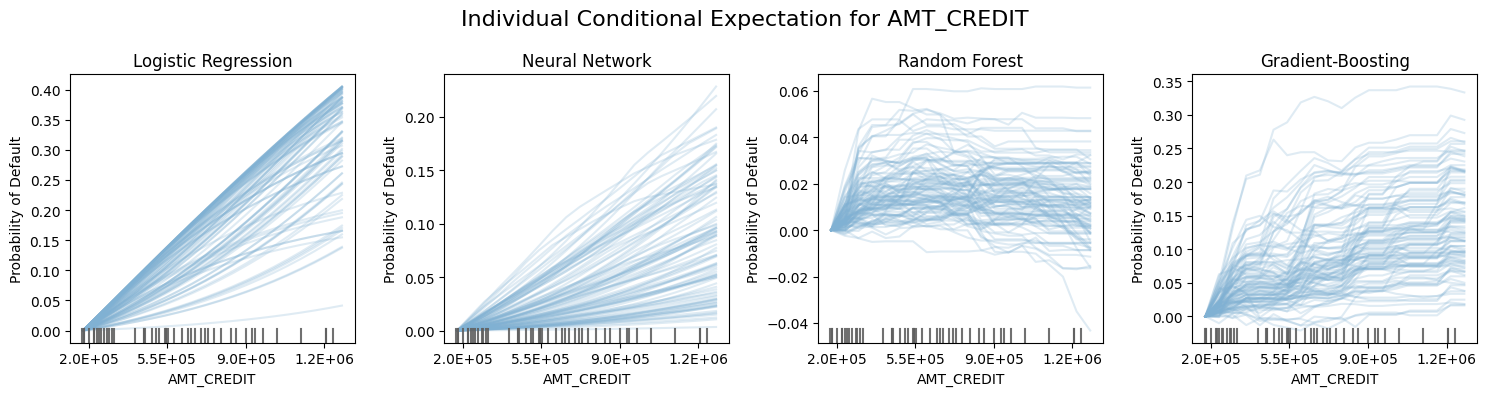

In [21]:
plot_ice(model_list, X_sample.head(100), "AMT_CREDIT")
plt.savefig("explainability_data/ice_credit.pdf", dpi = 300)

## SHAP and LIME

Ref for shap handling of categorical features: https://github.com/shap/shap/issues/397

In [48]:
model = joblib.load(f"../results/credit_models/{dataset_name}/{selected_fold}/LGBMClassifier.pkl")
Y_score = model.predict_proba(X_train)[:, 1]
threshold = ks_threshold(Y_train, Y_score)
print(f"Threshold for KS: {threshold:.2f}")

Threshold for KS: 0.48


In [63]:
shap_explainer = ShapPipelineExplainer(model, X_sample, method_explain="prob")
lime_explainer = LimePipelineExplainer(model, X_sample, method_explain="prob")

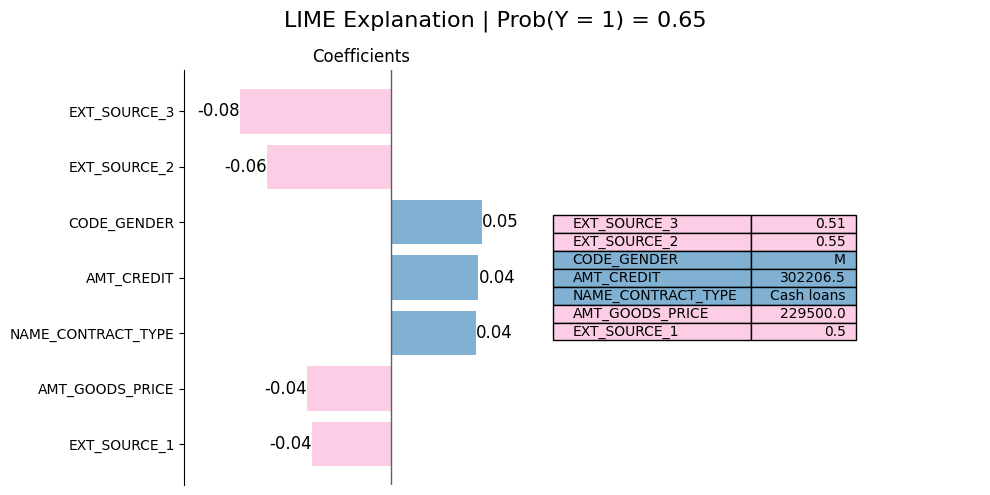

In [56]:
lime_explainer.plot_explanation(X_train.iloc[[2]])
prob = model.predict_proba(X_train.iloc[[2]])[0, 1]
plt.suptitle(f"LIME Explanation | Prob(Y = 1) = {prob:.2f}", fontsize = 16)
plt.savefig("explainability_data/lime.pdf", dpi = 300)

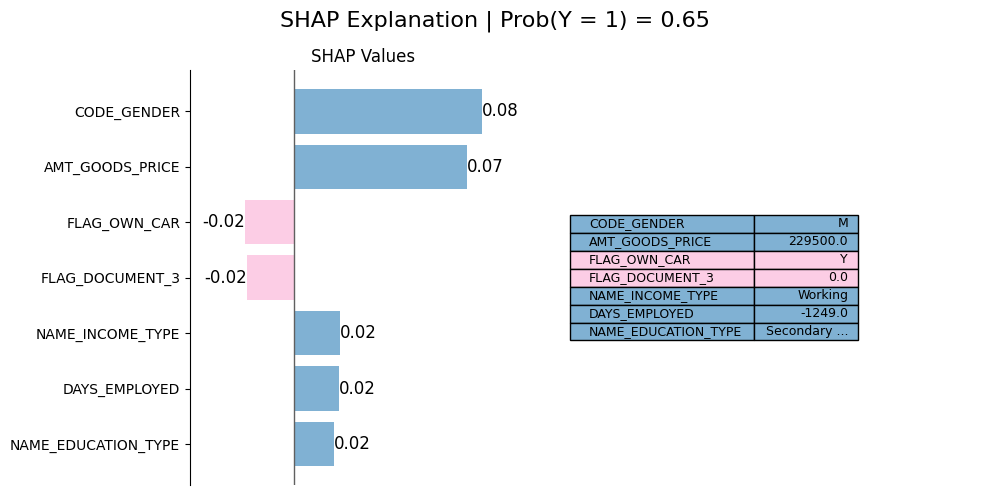

In [68]:
shap_explainer.plot_explanation(X_train.iloc[[2]])
prob = model.predict_proba(X_train.iloc[[2]])[0, 1]
plt.suptitle(f"SHAP Explanation | Prob(Y = 1) = {prob:.2f}", fontsize = 16)
plt.savefig("explainability_data/shap.pdf", dpi = 300)

## MAPOCAM

In [113]:
model = joblib.load(f"../results/credit_models/{dataset_name}/{selected_fold}/LogisticRegression.pkl")
Y_score = model.predict_proba(X_train)[:, 1]
threshold = ks_threshold(Y_train, Y_score)
X_train_positive = X_train[model.predict(X_train) == 1]
print(f"Threshold: {threshold:.2f}")

Threshold: 0.50


In [114]:
mutable_features = [
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "REGION_POPULATION_RELATIVE",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "DAYS_REGISTRATION",
    "OWN_CAR_AGE",
    "FLAG_MOBIL",
    "FLAG_EMP_PHONE",
    "FLAG_WORK_PHONE",
    "FLAG_CONT_MOBILE",
    "FLAG_PHONE",
    "FLAG_EMAIL",
    "REGION_RATING_CLIENT",
    "REGION_RATING_CLIENT_W_CITY",
    "REG_REGION_NOT_LIVE_REGION",
    "REG_REGION_NOT_WORK_REGION",
    "LIVE_CITY_NOT_WORK_CITY",
    "APARTMENTS_AVG",
    "BASEMENTAREA_AVG",
    "LANDAREA_AVG",
    "LIVINGAREA_AVG",
    "DAYS_LAST_PHONE_CHANGE",
]

In [115]:
method = MAPOCAM(
    model,
    X_train,
    mutable_features,
    target = 0,
    max_changes = 5,
    criteria = "percentile_changes",
    threshold=threshold,
    step_size = 0.05
)

In [116]:
cfs = method.fit(X_train_positive.iloc[[4]])

In [123]:
display_cfs(X_train_positive.iloc[[4]], cfs, model)

,Original,CF 2,CF 1,CF 0
AMT_CREDIT,277970,---,255049,255049
FLAG_EMAIL,0.0,1.0,1.0,1.0
REG_REGION_NOT_LIVE_REGION,0.0,1.0,1.0,1.0
BASEMENTAREA_AVG,0.088,0.293,0.279,0.249
DAYS_LAST_PHONE_CHANGE,-1438.0,---,---,-1727.0


### Dice

In [124]:
method = Dice(
    X_train,
    Y_train,
    model,
    n_cfs = 3,
    mutable_features = mutable_features,
)

In [127]:
cfs = method.fit(X_train_positive.iloc[[4]])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


In [128]:
display_cfs(X_train_positive.iloc[[4]], cfs, model) 

,Original,CF 1,CF 2,CF 0
AMT_INCOME_TOTAL,202500,---,12517048,13088718
BASEMENTAREA_AVG,0.088,0.666,---,---
LIVINGAREA_AVG,0.107,---,---,0.424
